# Comparing variations of the Invariant Risk Minimization (IRM) principle

This notebook illustrates the differences in implementation from the scalar formulation of the regularization term in IRMv1 and the theoretical formulation presented in the same work by Arjovski et al. (2019)

Some implementation details were inspired by the original implementation of [Arjovski et al. (2019)](https://github.com/facebookresearch/InvariantRiskMinimization) while others were taken from [Gulrajani and David Lopez-Paz (2020)](https://github.com/facebookresearch/DomainBed), also refered as `DomainBed`


*Note: in order to render the autograd graphs, please install [torchviz](https://github.com/szagoruyko/pytorchviz)*

Copyright (C) 2019. Huawei Technologies Co., Ltd. All rights reserved.
This program is free software; you can redistribute it and/or modify
it under the terms of the Apache 2.0 License.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
Apache 2.0 License for more details.


In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torchviz import make_dot

import flsuite.data as data
import flsuite.utils as utils

seed = 0
epochs = 60
batch_size = 64
weight_decay = 0.001 # as in original implementation
anneal = 500 # in steps as in DomainBed (original implementation is too early: 100)
penalty_coef = 1e2 # as in DomainBed (original implementation is too high: 1e4)

os.environ['CUDA_VISIBLE_DEVICES'] = str(1)
device = torch.device('cuda')

#### The dataset used for this experiment is ColoredMNIST

More information in [Gulrajani and David Lopez-Paz (2020)](https://arxiv.org/abs/2007.01434)

In [2]:
# load colored MNIST dataset
dataset = data.datasets.ColoredMNIST('../data/datasets')
train_set = data.merge_datasets(dataset.datasets[:-1])
test_set = dataset.datasets[-1]

train_dataloader = data.build_dataloaders([(train_set[0], train_set[1].float())], batch_size)[0]

# to calculate the autograd graphs
X_batch = train_set[0][:batch_size].to(device)
y_batch = train_set[1][:batch_size].to(torch.float)

#### The model is a simple multilayer perceptron for binary classification

In [10]:
class MLP(nn.Module):
    def __init__(self, seed = None):
        super().__init__()
        if seed is not None:
            torch.manual_seed(seed)
        self.lin1 = nn.Linear(28*28*2, 256)
        self.lin2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1, bias=False)

        self.criterion = nn.BCELoss()
        
    def forward(self, x):
        x = F.relu(self.lin1(x.view(x.shape[0], -1)))
        x = F.relu(self.lin2(x))
        return torch.sigmoid(self.out(x).view(-1))

def acc(model, dataset):
    output = model(dataset[0].to(device)).cpu()
    return (dataset[1] == output.round()).sum() / len(dataset[1])

#### Definition of the different IRM penalties
Obs.: In the implementation of DomainBed, a minibatch is splitted into two other batches to obtain a unbiased estimate on the norm of the gradient. This approach, however, does not guarantee that the overall result for the penalty is positive, what comes in conflict with the original intent

In [11]:
def irm_penalty_scalar(model, loss_fn, logits, y): # as in IRMv1
    scale = torch.tensor(1., device=logits.device).requires_grad_()
    loss = loss_fn(logits * scale, y)
    grad = autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(grad**2)

def irm_penalty_weights(model, loss_fn, logits, y): # as in original formulation
    loss = loss_fn(logits, y)
    grad = autograd.grad(loss, [model.out.weight], create_graph=True, retain_graph=True)[0]
    return torch.sum(grad**2)

#### Training function

In [12]:
def train(model, loss_func, optimizer, penalty_fn):
    
    #cast to device if necessary
    if next(model.parameters()).device != device:
        model.to(device)

    update_count = 0
    penalty_weight = 1.0 # as in domainbed
    
    for epoch in range(epochs):
        base_loss, base_penalty = 0.0, 0.0
                    
        for i, (images, target) in enumerate(train_dataloader):
            
            # cast batches to device
            images, target = images.to(device), target.to(device)
            outputs = model(images)

            loss = loss_func(outputs, target)
            penalty = penalty_fn(model, loss_fn, outputs, target)
            base_loss += loss
            base_penalty += penalty

            update_count += 1
            
            if update_count == anneal:
                penalty_weight = penalty_coef
                # avoid any optimization hickups when changing the penalization term
                optimizer = optimizer.__class__(model.parameters(), **optimizer.defaults)
        
        base_loss /= len(train_dataloader)
        base_penalty /= len(train_dataloader)

        optimizer.zero_grad()
        
        total_loss = base_loss + penalty_weight*base_penalty
        total_loss.backward()
        
        optimizer.step()
        
        if epoch % 5 == 0:
            print(f'[epoch {epoch:02d}] Loss: {total_loss.item():.4f} | Base loss: {base_loss.item():.4f} | Penalty: {base_penalty.item():.4f}')

    return model

### Case 1: training with scalar IRM penalty term

[epoch 00] Loss: 2.3355 | Base loss: 0.6900 | Penalty: 0.0165
[epoch 05] Loss: 2.3505 | Base loss: 0.6560 | Penalty: 0.0169
[epoch 10] Loss: 2.2336 | Base loss: 0.6623 | Penalty: 0.0157
[epoch 15] Loss: 2.1962 | Base loss: 0.6475 | Penalty: 0.0155
[epoch 20] Loss: 2.2387 | Base loss: 0.6259 | Penalty: 0.0161
[epoch 25] Loss: 2.1892 | Base loss: 0.6150 | Penalty: 0.0157
[epoch 30] Loss: 2.1523 | Base loss: 0.6129 | Penalty: 0.0154
[epoch 35] Loss: 2.2255 | Base loss: 0.6228 | Penalty: 0.0160
[epoch 40] Loss: 2.1309 | Base loss: 0.6226 | Penalty: 0.0151
[epoch 45] Loss: 2.1730 | Base loss: 0.6247 | Penalty: 0.0155
[epoch 50] Loss: 2.3253 | Base loss: 0.6237 | Penalty: 0.0170
[epoch 55] Loss: 2.3237 | Base loss: 0.6171 | Penalty: 0.0171
Train accuracy: 0.84908
Test accuracy: 0.09874


/home/artur/.local/lib/python3.6/site-packages/torchviz/dot.py:68: UserWarning: make_dot: showing grad_fn attributes and saved variables requires PyTorch version >= 1.9. (This does NOT apply to saved tensors saved by custom autograd functions.)
  "make_dot: showing grad_fn attributes and saved variables"


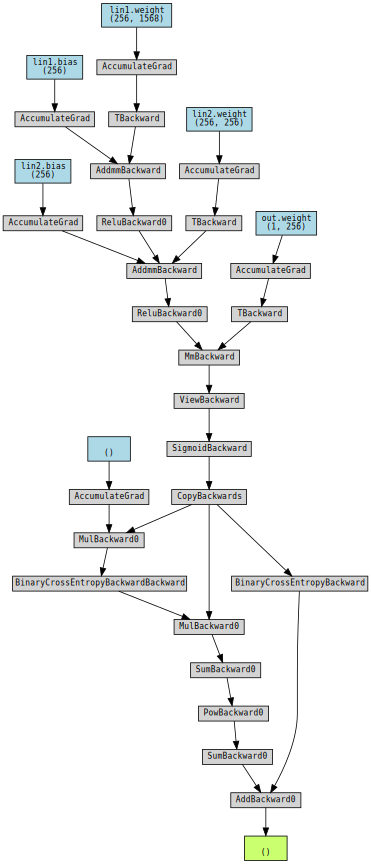

In [13]:
model = MLP(seed)
loss_fn = model.criterion
optim = torch.optim.Adam(model.parameters(), weight_decay=0.001)

model = train(model, loss_fn, optim, irm_penalty_scalar)

print('Train accuracy: %.5f' % acc(model, train_set))
print('Test accuracy: %.5f' % acc(model, (test_set[:][0],test_set[:][1])))

output0 = model(X_batch).cpu()
base_loss = model.criterion(output0, y_batch)
penalty = irm_penalty_scalar(model, model.criterion, output0, y_batch)
loss = base_loss + penalty

make_dot(loss, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

### Case 2: training with vectorized IRM penalty term

[epoch 00] Loss: 1.2318 | Base loss: 0.6900 | Penalty: 0.0054
[epoch 05] Loss: 0.7899 | Base loss: 0.6919 | Penalty: 0.0010
[epoch 10] Loss: 0.7144 | Base loss: 0.6927 | Penalty: 0.0002
[epoch 15] Loss: 0.6964 | Base loss: 0.6930 | Penalty: 0.0000
[epoch 20] Loss: 0.6935 | Base loss: 0.6930 | Penalty: 0.0000
[epoch 25] Loss: 0.6932 | Base loss: 0.6931 | Penalty: 0.0000
[epoch 30] Loss: 0.6932 | Base loss: 0.6931 | Penalty: 0.0000
[epoch 35] Loss: 0.6932 | Base loss: 0.6931 | Penalty: 0.0000
[epoch 40] Loss: 0.6931 | Base loss: 0.6931 | Penalty: 0.0000
[epoch 45] Loss: 0.6931 | Base loss: 0.6931 | Penalty: 0.0000
[epoch 50] Loss: 0.6931 | Base loss: 0.6931 | Penalty: 0.0000
[epoch 55] Loss: 0.6931 | Base loss: 0.6931 | Penalty: 0.0000
Train accuracy: 0.59286
Test accuracy: 0.43342


/home/artur/.local/lib/python3.6/site-packages/torchviz/dot.py:68: UserWarning: make_dot: showing grad_fn attributes and saved variables requires PyTorch version >= 1.9. (This does NOT apply to saved tensors saved by custom autograd functions.)
  "make_dot: showing grad_fn attributes and saved variables"


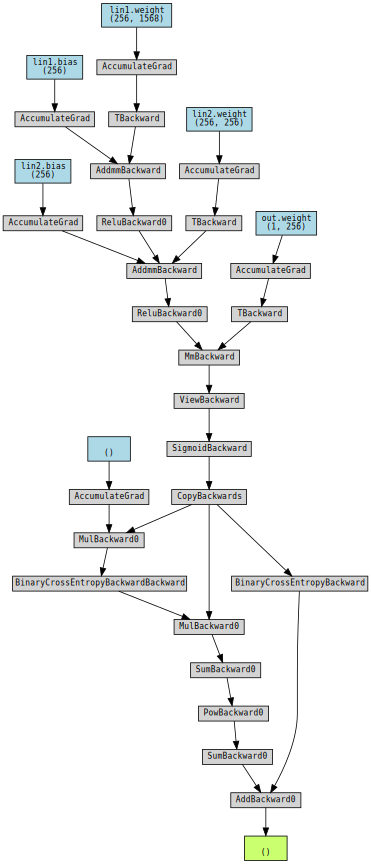

In [14]:
model = MLP(seed)
loss_fn = model.criterion
optim = torch.optim.Adam(model.parameters(), weight_decay=0.001)

model = train(model, loss_fn, optim, irm_penalty_weights)

print('Train accuracy: %.5f' % acc(model, train_set))
print('Test accuracy: %.5f' % acc(model, (test_set[:][0],test_set[:][1])))

output1 = model(X_batch).cpu()
base_loss = model.criterion(output1, y_batch)
penalty = irm_penalty_scalar(model, model.criterion, output1, y_batch)
loss = base_loss + penalty

make_dot(loss, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

Notably, both autograd graphs are very similar, despite their differences in the penalty calculation.

Nevertheless, their results with the same penalty coefficient and annealing term are very distinct.
Once the regularization term kicks in, the penalty term in the latter case quickly goes to zero.
This is not observed in the first case, where the penalty term is hardly fazed throughout training.